In [1]:
# Import all the libraries I need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ignore Deprecation Warning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.pipeline import make_pipeline

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers


from keras.models import Sequential # intitialize the ANN
from keras.layers import Dense, Activation, Dropout      # create layers

import pyarrow.parquet as pq
import pyarrow as pa

from sklearn.neighbors import KNeighborsClassifier

np.random.seed(421)
tf.random.set_seed(421)



In [2]:
#Ryans path
#base_path = '/Users/ryan/neue_fische/human-protein-atlas-image-classification/data/'
#embed_path = '/Users/ryan/neue_fische/human-protein-atlas-image-classification/data/embeddings_train/'

#Gwens path
base_path = '../data/human-protein-atlas-image-classification_data/'
embed_path = '../data/human-protein-atlas-image-classification_data/embeddings_train/'

In [3]:
#Get classes from other notebooks
from Helper_classes import Location_in_Target, Bin_Embedding, Prepared_Test_Train_Data, Prepare_NN_for_pipline

In [4]:
#get all of the labels
labels_training = pd.read_csv(base_path+'train.csv')

In [5]:
labels_training

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18
...,...,...
31067,ffed4430-bbac-11e8-b2ba-ac1f6b6435d0,21
31068,fff0a998-bbae-11e8-b2ba-ac1f6b6435d0,5
31069,fff189d8-bbab-11e8-b2ba-ac1f6b6435d0,7
31070,fffdf7e0-bbc4-11e8-b2bc-ac1f6b6435d0,25 2 21


#### Test the class with Mitochondria labeled with a 23
Create a balanced subset of images that have mitochondria or not.

In [7]:
mitochondria_pictures = Location_in_Target(location = 23)
mitochondria_pictures.determine_pictures(labels_training)

In [6]:
mitochondria_pictures.get_pictures()

""


Get the embedded data for the mitochondria data and the same amount of data not labeled with mitochondria.

In [6]:
bin_embed_mit = Bin_Embedding(mitochondria_pictures.get_pictures(), 23, embed_path)

### Split into train/test and transform/standardize

In [7]:
prepared_data_mit = Prepared_Test_Train_Data(bin_embed_mit.get_embedding())
X_train, X_test, y_train, y_test = prepared_data_mit.splitter()

In [8]:
X_train.shape, y_train.shape, np.isnan(X_train).sum().sum(), y_train.isna().sum(), np.isnan(X_train).sum().sum()

((4447, 1280), (4447,), 0, 0, 0)

### Models

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-07-07 16:05:59.522866: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-07 16:05:59.523367: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


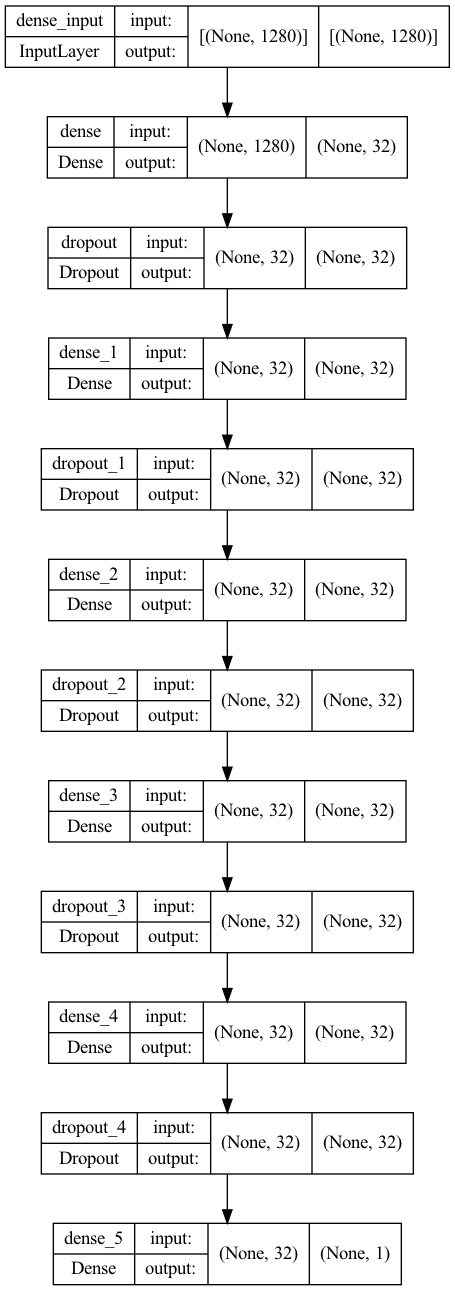

In [8]:
nn_model_mit = Prepare_NN_for_pipline()
nn_model_mit.build_layers(number_layers=6, dropout_rate=0.25)
plot_model(
    nn_model_mit.model, to_file='model.png', show_shapes=True, 
    show_layer_names=True, dpi=96
)

In [9]:
regressor_mit = nn_model_mit.build_regressor(n_train = len(X_train))

In [10]:
with tf.device('/cpu:0'):

    # just create the pipeline
    nn_pipe_mit = make_pipeline(QuantileTransformer(random_state=0), StandardScaler(), regressor_mit)
    training = nn_pipe_mit.fit(X_train, y_train)  # apply scaling on training data

Epoch 1/2000


2022-07-07 16:06:06.614639: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/4 [======>.......................] - ETA: 1s - loss: 0.6932 - accuracy: 0.4870

2022-07-07 16:06:07.018295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 40ms/step - loss: 0.6932 - accuracy: 0.5018 - val_loss: 0.6932 - val_accuracy: 0.5011
Epoch 2/2000
4/4 [==============================] - 0s 11ms/step - loss: 0.6932 - accuracy: 0.5075 - val_loss: 0.6932 - val_accuracy: 0.5011
Epoch 3/2000
4/4 [==============================] - 0s 12ms/step - loss: 0.6931 - accuracy: 0.5075 - val_loss: 0.6932 - val_accuracy: 0.5011
Epoch 4/2000
4/4 [==============================] - 0s 11ms/step - loss: 0.6931 - accuracy: 0.5075 - val_loss: 0.6932 - val_accuracy: 0.5011
Epoch 5/2000
4/4 [==============================] - 0s 12ms/step - loss: 0.6931 - accuracy: 0.5075 - val_loss: 0.6932 - val_accuracy: 0.5011


2022-07-07 16:06:07.243535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 6/2000
4/4 [==============================] - 0s 11ms/step - loss: 0.6931 - accuracy: 0.5075 - val_loss: 0.6932 - val_accuracy: 0.5011
Epoch 7/2000
4/4 [==============================] - 0s 11ms/step - loss: 0.6931 - accuracy: 0.5075 - val_loss: 0.6932 - val_accuracy: 0.5011
Epoch 8/2000
4/4 [==============================] - 0s 11ms/step - loss: 0.6931 - accuracy: 0.5075 - val_loss: 0.6932 - val_accuracy: 0.5011
Epoch 9/2000
4/4 [==============================] - 0s 11ms/step - loss: 0.6931 - accuracy: 0.5075 - val_loss: 0.6932 - val_accuracy: 0.5011
Epoch 10/2000
4/4 [==============================] - 0s 11ms/step - loss: 0.6930 - accuracy: 0.5075 - val_loss: 0.6931 - val_accuracy: 0.5011
Epoch 11/2000
4/4 [==============================] - 0s 11ms/step - loss: 0.6927 - accuracy: 0.5075 - val_loss: 0.6927 - val_accuracy: 0.5011
Epoch 12/2000
4/4 [==============================] - 0s 11ms/step - loss: 0.6920 - accuracy: 0.5075 - val_loss: 0.6917 - val_accuracy: 0.5011
Epoch 13/2

In [11]:
# summarize history for accuracy
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

AttributeError: 'Pipeline' object has no attribute 'history'

### !!!! turning on regularizers seems to stall model, results don't improve just stuck under 0.5 for both train and validate. Running on test data shows it is only able to predict 1, never guesses 0


2022-07-06 16:15:25.221338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


0.49

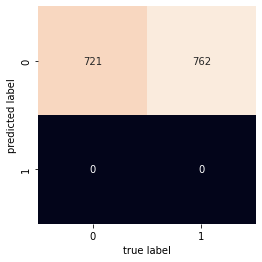

In [33]:
y_pred = model.predict(X_test)

# Plotting the confusing matrix
mat = confusion_matrix(y_test, y_pred.round())
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

accuracy_score(y_test, y_pred.round()).round(2)